In [1]:
# Importing the basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In this notebook we are going to train linear and logistic regression models on the insurance dataset.

### Dataset
The insurance dataset contains details of individuals from the United States with following characteristics in different columns:
- *age*: age 
- *sex*: gender
- *bmi*: body mass index
- *children*: number of children
- *smoker*: smoker or not
- *region*: which region of USA they belong to 
- *charged*: insurance claim amount
- *insured*: if the individual will get an insurance or not

For insurance companies it is very important to to know beforehand how much claim can be expected from their customers, and based on that premiums are typically estimated they want to charge. The other important decicion these companies need to make is: should they accept insurance applications from new customers or not. 
Therefore, following are the two predictive modelling tasks we would like to perform:
1. Build a model using linear regression to predict insurance claim amount of individuals
2. Build a model using logistic regression to predict if an individual will be insured or not

## 1.  *Linear regression* model to predict insurance claim amount of individuals

### 1.1 Exploratory data analysis
The first step in the ML pipeline is to do through EDA to understand the data, remove and if required impute NaNs, check outliers, find correlations among variables, remove highly correlated variables, etc. 

In [2]:
#Reading the data
df = pd.read_csv("../../datasets/insurance.csv")
print('Original length of dataframe:', len(df))
df.head()

Original length of dataframe: 1338


,age,sex,bmi,children,smoker,region,charges,insured
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,0


In [3]:
# Checking Nans and if required removing them
print('Printing total number of NaNs in the dataframe,', df.isnull().sum().sum())

Printing total number of NaNs in the dataframe, 0


In [4]:
# preliminary descriptive statistics
df.describe()

,age,bmi,children,charges,insured
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.679372
std,14.049960,6.098187,1.205493,12110.011237,0.466892
min,18.000000,15.960000,0.000000,1121.873900,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000


#### 1.1a) Basic visual plots

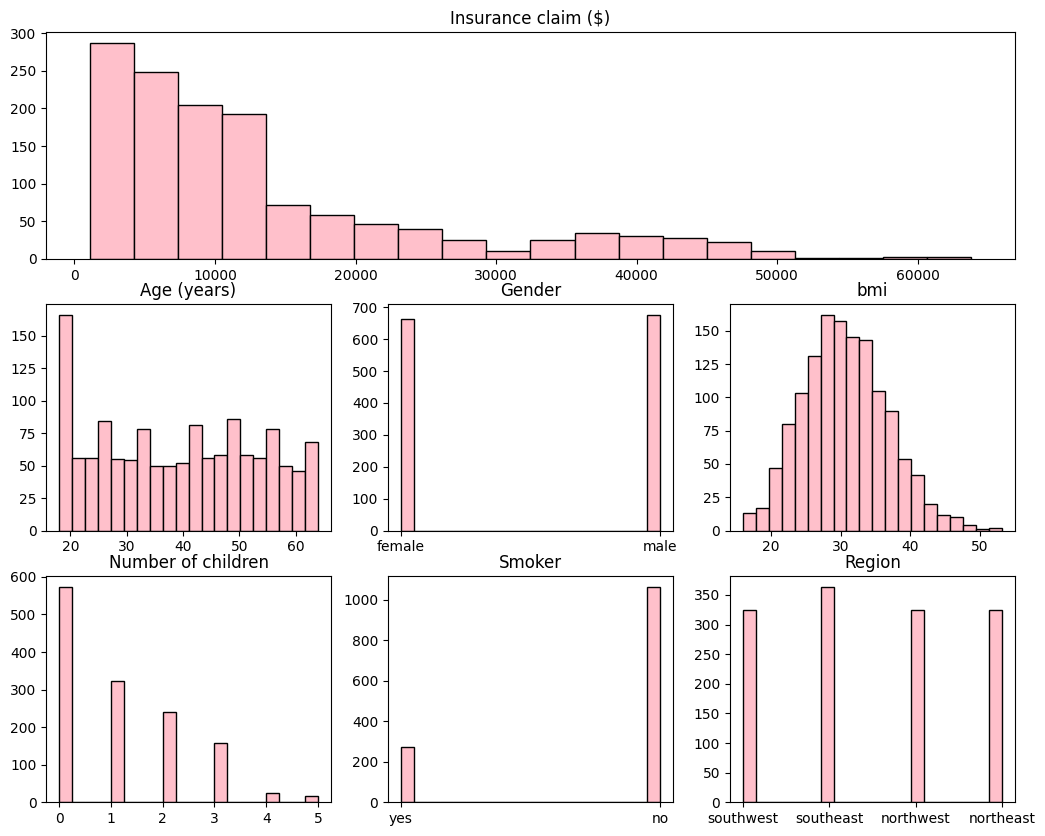

In [5]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(12.5, 10), dpi=100)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[1,2])
ax5=fig.add_subplot(gs[2,0])
ax6=fig.add_subplot(gs[2,1])
ax7=fig.add_subplot(gs[2,2])

# Histogram plot of charges
ax1.hist(df['charges'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax1.set_title('Insurance claim ($)')

# Histogram plot of age
ax2.hist(df['age'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax2.set_title('Age (years)')

# Histogram plot of sex
ax3.hist(df['sex'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax3.set_title('Gender')

# Histogram plot of bmi
ax4.hist(df['bmi'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax4.set_title('bmi')

# Histogram plot of children
ax5.hist(df['children'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax5.set_title('Number of children')

# Histogram plot of smoker
ax6.hist(df['smoker'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax6.set_title('Smoker')

# Histogram plot of region
ax7.hist(df['region'], bins = 20, facecolor = 'pink', edgecolor = 'k')
ax7.set_title('Region')

plt.show()

In [6]:
# Getting some basic statistics
claim_55000 = len(df[df['charges'] > 55000])
print('Number of insurance claims greater 55000 $ is', claim_55000)
bmi_40= len(df[df['bmi'] > 40])
print('Individuals with bmi greater 40 is', bmi_40)
child_3= len(df[df['children'] <= 3])
print('Individuals withless than equal to 3 children', child_3)

Number of insurance claims greater 55000 $ is 5
Individuals with bmi greater 40 is 91
Individuals withless than equal to 3 children 1295


From the plot above we can see the following:
- there are 5 insurance claims > 55000$
- the age is almost equal distrubted between 20-65 years
- the gender of individuals are equally distributed
- there are 91 individuals with bmi > 50, which is way above the average BMI of USA, however will we keep these data
- most individuals (1295) have $\leq 3$ children 
- data has more many more non- smokers than smokers
- number of individuals from different regions are also equally distributed

##### 1.1b) Correlation analysis
For this we will first check which feature variables are correlated to the target variable. Note that we have both continuous and categorical feature variables, and the target variable is a continuous variable. Therefore, we will have to use different correlation methods, based on the nature of the variables.
- continuous <-> continuous -> Pearson's linear correlation
- ordinal <-> ordinal -> Spearman's rank correlation for understanding montonic relationships. Can also be used for continuous variables to study non linear associations.  
- nominal <-> nomial -> Cramer's V test 
- nominal <-> continuous -> t-tests/ANOVA/Kruskal-Wallis H-test

**NOTE:** The list above is not exhaustive, there are more methods to calculate correlation/association among variables. You are expected to research on them based on the nature of the datatset.

In [7]:
# defining the continuous and categorical feature variables
cont_var = ['age', 'bmi', 'children', 'charges']
cont_features = ['age', 'bmi', 'children']
nominal_var = ['sex', 'smoker', 'region']

In [8]:
# We check the spearman correlation coefficient between the continuous feature variables with the target variable.
df[cont_var].corr(method='spearman')

,age,bmi,children,charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
charges,0.534392,0.119396,0.133339,1.000000


From above we see that *age* has the highest correlation with *charges*, *bmi* and *children* have rather low correlation with *charges*. We will still keep them in the linear regression model, and use the regularization method to avoid overfitting.

In [9]:
# Now we will test the if there is association between charges and the nominal categorical variables.
# We will use the non-parametric Kruskal-Wallis H test
# NOTE: One important requirement for Kruskal-Wallis H test is that each segment should have more than 5 data points (check ANOVA demonstration notebook). 
#       The is indeed true for each norminal variable segments.

# Getting data for each normical variable segments
#sex
female_charges = df[df['sex'] =='female']['charges'].values
male_charges = df[df['sex'] =='male']['charges'].values
#smoker
smoker_charges = df[df['smoker'] =='yes']['charges'].values
non_smoker_charges = df[df['smoker'] =='no']['charges'].values
#region 
nw_charges = df[df['region'] =='northwest']['charges'].values
ne_charges = df[df['region'] =='northeast']['charges'].values
sw_charges = df[df['region'] =='southwest']['charges'].values
se_charges = df[df['region'] =='southeast']['charges'].values

# Kruskal-Wallis H tests
import scipy.stats as stats

alpha = 0.1

test_stat, p_val = stats.kruskal(female_charges, male_charges)
print('The p-value for Kruskal-Wallis H test for gender:', p_val)

test_stat, p_val = stats.kruskal(smoker_charges, non_smoker_charges)
print('The p-value for Kruskal-Wallis H test for smoker:', p_val)

test_stat, p_val = stats.kruskal(nw_charges, ne_charges, sw_charges, se_charges)
print('The p-value for Kruskal-Wallis H test for region:', p_val)

The p-value for Kruskal-Wallis H test for gender: 0.7285979314956946
The p-value for Kruskal-Wallis H test for smoker: 5.259018267498522e-130
The p-value for Kruskal-Wallis H test for region: 0.19232908072121002


From the above Kruskal-Wallis H test we can see that:
- the p-value for *gender* is very high ($> \alpha = 0.1$), this implies that statistically the mean of charges between female and male are not different. 
- the p-value for *smoker* is very low ($ << \alpha = 0.1$), this implies that statistically the mean of chrarges between smoker and not smoker are different.
- the p-value for *region* is at the limit ($ \approx \alpha = 0.1$), this implies that statistically the mean of charges between regions are not very different. Given this is a boundary case, we still keep this variable in for building the model. 


We visually check the difference in histogram of claim charges for the different segments of the nominal feature variables.

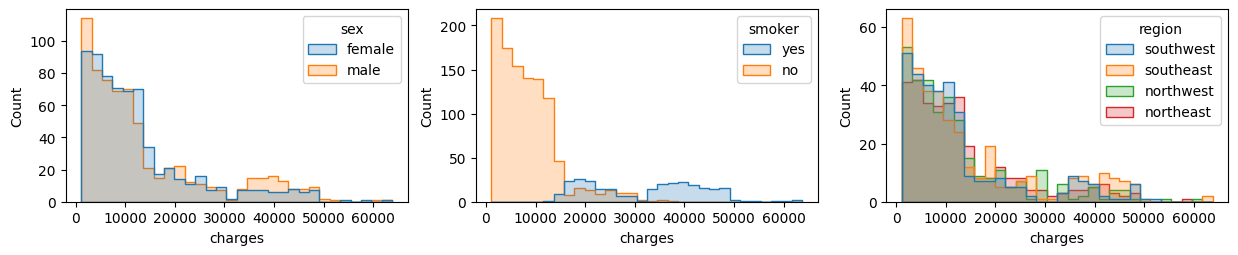

In [10]:
fig = plt.figure(figsize=(15, 2.5), dpi=100)
plt.subplot(1,3,1)
sns.histplot(data=df, x="charges", hue="sex", element="step")
plt.subplot(1,3,2)
sns.histplot(data=df, x="charges", hue="smoker", element="step")
plt.subplot(1,3,3)
sns.histplot(data=df, x="charges", hue="region", element="step")

plt.show()

- From the plot above, we can also visually see that for *smoker* the claim charges are indeed very different. This is also somewhat true for *region*. However, for *gender*, the histogram do not look very different, we have also confirmed this from the the above statistical test. 
- As a data scientist it is important that you show both, the statistical test results and visually present you observations.

**QUESTION**: Is it ethical to you gender as a feature variable for predicting insurance claim for this usecase? 



##### 1.1c) Checking for multicollinearity
- This is a situation when one more than two predictor variables are correlated.
- Multicollinearity can inflate the variance of the predictor coefficients, which becomes an issue while interpreting feature contribution to predictions.
-  This is important to check multicollinearity for Generalized Linear Models (GLMs), both linear regression and logistic regressions are a part of GLMs.
- There are different methods to test for multicolinearity among the predictor/indepdendent variables. 
- One is to check the pairwise correlation between the variables. We have already seen above that correlation between the continous variables are:
    - age <-> bmi = 0.1
    - age <-> children = 0.06
    - bmi <-> children =  0.016
    <br>
    All the correlations are pretty low. 
    - We are still to check the correlation between the other variables: 
      - age <-> region
      - age <-> smoker
      - bmi <-> region 
      - bim <-> smoker
      - children <-> region
      - children <-> smoker
      <br>
    - **QUESTION**: Find the collinearity among the rest of the variables mentioned above using appropriate correlation methods. 
- Just looking into pair wise collinearity can give only a limited view, think of a situation when we can predict age from children + bmi?
- The other method can be to check the variation inflation factor (VIF) between the variables, which helps in overcoming the pairwise correlation issue. Some of you have already used this in the Business Statistics course. Further reading: https://online.stat.psu.edu/stat462/node/180/
- Another way is to use the regularization method with regression to remove multicollinearity. However, it is best to check for them beforehand.

Given we have categorical data, before computing VIF, we need to convert them into number. For that we will use dummy coding and drop the first column. This is because in dummy coding, you can always retrive the first column from the rest.


In [11]:
# Getting dummy variables for the categorical variables
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,age,bmi,children,charges,insured,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,False,True,False,False,True
1,18,33.770,1,1725.55230,0,True,False,False,True,False
2,28,33.000,3,4449.46200,0,True,False,False,True,False
3,33,22.705,0,21984.47061,1,True,False,True,False,False
4,32,28.880,0,3866.85520,0,True,False,True,False,False


In [12]:
###################
## Computing VIF ##
###################
from statsmodels.stats.outliers_influence import variance_inflation_factor

dummy_features = ['age', 'bmi', 'children', 'sex_male','smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
# creating a dataframe for saving the VIF values
df_vif = pd.DataFrame()
df_vif["feature"] = dummy_features
# calculating VIF for each feature
vif = [variance_inflation_factor(np.array(df_dummies[dummy_features].values, dtype=float), i) for i in range(len(dummy_features))]
df_vif['vif'] = vif

df_vif.sort_values(by = 'vif')

,feature,vif
4,smoker_yes,1.261233
2,children,1.809930
5,region_northwest,1.890281
7,region_southwest,1.960745
3,sex_male,2.003185
6,region_southeast,2.265564
0,age,7.686965
1,bmi,11.358443


A rule of thumb is that if  VIF > 10 then multicollinearity is high. A cutoff of 5 is generally used. We see than *bmi* has VIF > 10, also from correlation analysis we saw that bmi <-> charges = 0.12. Based on these two factor we can in-principle drop bmi from our analysis. 
<br/>
There are several ways to select features:
- train two models: one without using *bmi*, and another using *bmi*, then see which model performs better for the test dataset. 
- other way is, if you do not want to throw bmi use the regularization method in linear regression.
- another way is to do principal component analysis (PCA) on the dataset and use the most important components as the features (you will learn this later in this course!) 

*Remember*, there is no one way for ML model building, it is bit of a craft that one needs to learn!

In [13]:
# Checking how the VIF values become without bmi
dummy_features_bmi = ['age', 'children', 'sex_male','smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
# creating a dataframe for saving the VIF values
df_vif = pd.DataFrame()
df_vif["feature"] = dummy_features_bmi
# calculating VIF for each feature
vif = [variance_inflation_factor(np.array(df_dummies[dummy_features_bmi].values, dtype=float), i) for i in range(len(dummy_features_bmi))]
df_vif['vif'] = vif

df_vif.sort_values(by = 'vif')

,feature,vif
3,smoker_yes,1.249792
4,region_northwest,1.706783
6,region_southwest,1.715200
1,children,1.762729
5,region_southeast,1.795873
2,sex_male,1.884719
0,age,3.850843


In [14]:
# Checking how the VIF values become without gender and bmi
dummy_features_sex_bmi = ['age', 'children','smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
# creating a dataframe for saving the VIF values
df_vif = pd.DataFrame()
df_vif["feature"] = dummy_features_sex_bmi
# calculating VIF for each feature
vif = [variance_inflation_factor(np.array(df_dummies[dummy_features_sex_bmi].values, dtype=float), i) for i in range(len(dummy_features_sex_bmi))]
df_vif['vif'] = vif

df_vif.sort_values(by = 'vif')

,feature,vif
2,smoker_yes,1.232968
3,region_northwest,1.684799
5,region_southwest,1.691921
1,children,1.752809
4,region_southeast,1.765175
0,age,3.528212


### 1.2 Feature engineering
In this step, a datascient needs to perform various tasks such as:
- creating new features from existing ones (requires domain knowledge)
- scaling the features, remember gradient descent method works well when the features are in the same scale 
<br/>
**IMPORTANT**: It is very important to note that we first do feature scaling on the training dataset and use the parameters from the training dataset to scale the test data.

**Train-Test Split**
We generally divide the original dataset randomly into 90/10 split (can also be 80/20% or 95/5% split, depending on the size of the original dataset). 
- *Training dataset*: 90% of the original dataset is used to train the ML model. Traning means estimating the model parameters.
- *Test dataset*: 10% of the original dataset is used to test the trained ML model's peformance. This dataset is sacred! You should not do anything with this other that measuring how well the model is performing. Ideally, this dataset is taken out even before doing the EDA part. So, as an ideal data scientist you should also do the same. Do the EDA on the traning dataset only!

There is another split done to the Training dataset called the *Validation dataset*. From the Traning dataset a part is kept for hyper-parameter tuning. But that is for the next practical session. For now, we will only focus on training and testing.

In [ ]:
######################
## Train-Test split ##
######################
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_dummies, test_size=0.1, random_state = 1009) 

# As a standard practice generally ML practitioners rename variable into X_train, X_test, y_train, y_test
X_train = df_train[dummy_features] 
y_train = df_train['charges']
X_test = df_test[dummy_features] 
y_test = df_test['charges']

######################################################
## Scaling the feature variables using MinMaxScaler ##
######################################################
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# define min max scaler instance
scaler = MinMaxScaler()
# Fitting the MinMaxScaler to X_train
scaler.fit(X_train)
# Scaling X_train used the fitting MinMax scalar to the traning dataset
X_train_scaled = scaler.transform(X_train)
# transforming X_train_scaled to pandas dataframe 
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=dummy_features)

# IMPORTANT: To scale X_test use the MinMaxScalar fitted to the traning dataset. The scaled X_test will only be used for model assessment!
# NOTE: DO not fit the MinMaxScaler to the test dataset. If you do then you are using information from the test dataset and will bias your model.
# Test datset is sacred, any properties from the test dataset SHOULD NOT be used. 
X_test_scaled = scaler.transform(X_test)
# transforming X_test_scaled to pandas dataframe 
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=dummy_features)

### 1.3 Model training
In this part we will train 3 linear regression models:
- Using all the variables (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- Not using *gender* and *bmi* as discussed earlier
- Using Ridge-regularization method (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge).
  Read the documentation of the model, you will notice it has a vary important parameter called alpha. This is a hyperparameter which can be in principle tuned. But for this lab we will use the default value. What is the default value?

In [16]:
######################################################
## Fitting three different Linear regression models ##
######################################################
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# The first linear regression model using all the variables
regressor1 = LinearRegression().fit(df_X_train_scaled, y_train)
print('-------------------------------------------------------------------------')
print('Model fitted using all the feature variables') 
print('R-2 value on training data', regressor1.score(df_X_train_scaled, y_train))
print('-------------------------------------------------------------------------')

# The second linear regression model leaving our sex and bmi
regressor2 = LinearRegression().fit(df_X_train_scaled[dummy_features_sex_bmi], y_train)
print('-------------------------------------------------------------------------')
print('Model fitted using without sex and bmi') 
print('R-2 value on training data', regressor2.score(df_X_train_scaled[dummy_features_sex_bmi], y_train))
print('-------------------------------------------------------------------------')

# The third linear regression model using ridge regression and all the features, alpha = 1 (default)
print('-------------------------------------------------------------------------')
print('Ridge regression model fitted using all the feature variables') 
regressor3 = Ridge(alpha = 1).fit(df_X_train_scaled, y_train)
print('R-2 value on training data', regressor3.score(df_X_train_scaled, y_train))
print('-------------------------------------------------------------------------')


-------------------------------------------------------------------------
Model fitted using all the feature variables
R-2 value on training data 0.7529018262634902
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Model fitted using without sex and bmi
R-2 value on training data 0.7256711504955784
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Ridge regression model fitted using all the feature variables
R-2 value on training data 0.7528499575231878
-------------------------------------------------------------------------


### 1.4 Model assessment
Time to assess which model is performing the best on the sacred/unseen/test dataset!
- Mean Absolute Error (MAE): easiest to explain to non technical managers
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSEA)
- $R^2$ 

Sklearn has a whole list: https://scikit-learn.org/stable/modules/model_evaluation.html

NOTE: In general, we also looks into these metrics value for training data too. The values of these metric are generally better for the training dataset compared to the test dataset, unless we have over-fitted the model. Let us check that.

In [ ]:
actual = [1, 2, 3]
predicted = [5, 2, 4]

def calculate_mean_squared_error(actual, predicted):
    err = 0
    for i in range(len(actual)):
        err += (actual[i] - predicted[i])**2
    return err/len(actual)

In [17]:
# get the predictions on the train dataset from the 3 models
y_train_pred_1 = regressor1.predict(df_X_train_scaled)
y_train_pred_2 = regressor2.predict(df_X_train_scaled[dummy_features_sex_bmi])
y_train_pred_3 = regressor3.predict(df_X_train_scaled)

# get the predictions on the test dataset from the 3 models
y_test_pred_1 = regressor1.predict(df_X_test_scaled)
y_test_pred_2 = regressor2.predict(df_X_test_scaled[dummy_features_sex_bmi])
y_test_pred_3 = regressor3.predict(df_X_test_scaled)

# Import all the necessary model evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('-------------------------------------------------------------------------')
print('Metrics for model 1, linear regression with all variables')
print('MAE train: %.3f, MAE test: %.3f' % (mean_absolute_error(y_train, y_train_pred_1), mean_absolute_error(y_test, y_test_pred_1)))
print('MSE train: %.3f, MSE test: %.3f' % (mean_squared_error(y_train, y_train_pred_1), mean_squared_error(y_test, y_test_pred_1)))
print('RMSE train: %.3f, RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_train, y_train_pred_1)), np.sqrt(mean_squared_error(y_test, y_test_pred_1))))
print('R-2 train: %.3f, R-2 test: %.3f' % (r2_score(y_train, y_train_pred_1), r2_score(y_test, y_test_pred_1)))
print('-------------------------------------------------------------------------')

print('-------------------------------------------------------------------------')
print('Metrics for model 2, linear regression wihout sex and bmi')
print('MAE train: %.3f, MAE test: %.3f' % (mean_absolute_error(y_train, y_train_pred_2), mean_absolute_error(y_test, y_test_pred_2)))
print('MSE train: %.3f, MSE test: %.3f' % (mean_squared_error(y_train, y_train_pred_2), mean_squared_error(y_test, y_test_pred_2)))
print('RMSE train: %.3f, RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_train, y_train_pred_2)), np.sqrt(mean_squared_error(y_test, y_test_pred_2))))
print('R-2 train: %.3f, R-2-test: %.3f' % (r2_score(y_train, y_train_pred_2), r2_score(y_test, y_test_pred_2)))
print('-------------------------------------------------------------------------')

print('-------------------------------------------------------------------------')
print('Metrics for model 3, Ridge linear regression with all variables')
print('MAE train: %.3f, MAE test: %.3f' % (mean_absolute_error(y_train, y_train_pred_3), mean_absolute_error(y_test, y_test_pred_3)))
print('MSE train: %.3f, MSE test: %.3f' % (mean_squared_error(y_train, y_train_pred_3), mean_squared_error(y_test, y_test_pred_3)))
print('RMSE train: %.3f, RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_train, y_train_pred_3)), np.sqrt(mean_squared_error(y_test, y_test_pred_3))))
print('R-2 train: %.3f, R-2-test: %.3f' % (r2_score(y_train, y_train_pred_3), r2_score(y_test, y_test_pred_3)))
print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Metrics for model 1, linear regression with all variables
MAE train: 4179.356, MAE test: 4064.950
MSE train: 36648090.940, MSE test: 35294165.911
RMSE train: 6053.767, RMSE test: 5940.889
R-2 train: 0.753, R-2 test: 0.730
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Metrics for model 2, linear regression wihout sex and bmi
MAE train: 4061.281, MAE test: 3895.980
MSE train: 40686778.345, MSE test: 37631639.214
RMSE train: 6378.619, RMSE test: 6134.463
R-2 train: 0.726, R-2-test: 0.712
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Metrics for model 3, Ridge linear regression with all variables
MAE train: 4170.995, MAE test: 4055.221
MSE train: 36655783.795, MSE test: 35218354.865
RMSE train: 6054.402, RMSE test: 5

**QUESTIONS**: 
- Based on the metrics above which model will you conclude to be best performing and why? 
- Why is the $R^2$ of model 2 is lower than model 1 and model 2, even though its MAE is lower compared to the other two models?
- Can you implement the $adjusted-R^2$ metric? Why is it better than the $R^2$ metric?
- Use the StandardScaler from sklearn to scale the data and see how the performance of these models vary.

## 2.  *Logistic regression* model to predict if an individual will be insured or not

### 2.1 Exploratory data analysis
Given we have already done some EDA for the linear regression part, we will look into new plots w.r.t the binary classification problem.  

#### 2.1a) Basic visual plots
Let us check how the distribution of the feature variables look like for insured and not-insured individuals.

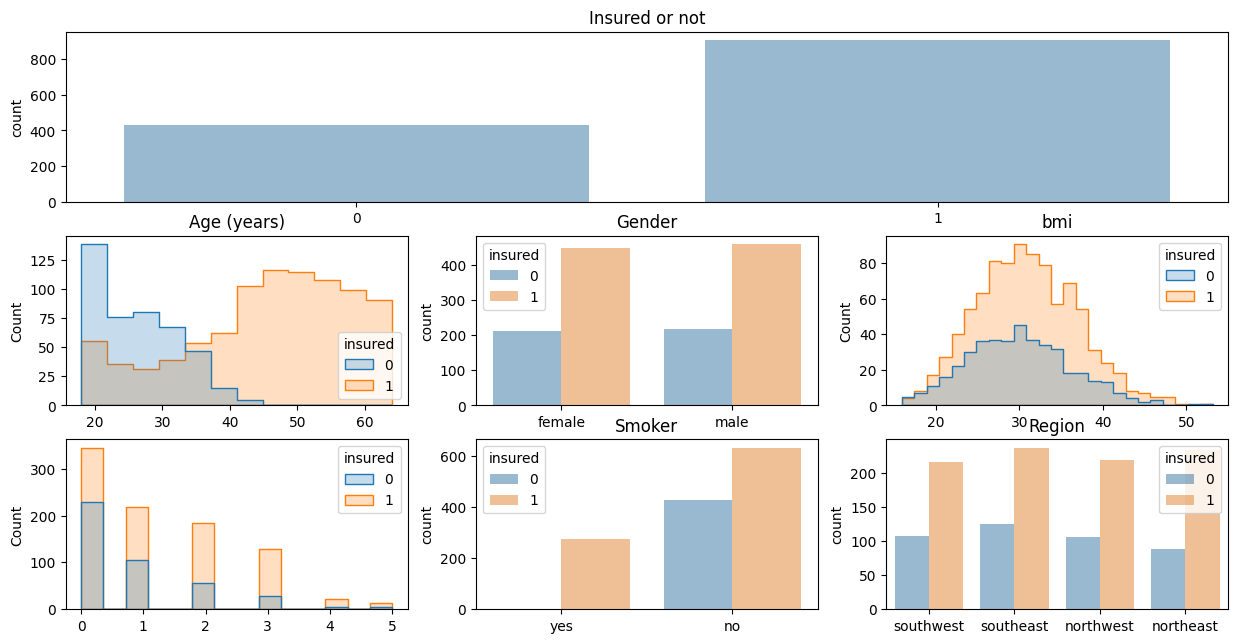

In [18]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(15, 7.5), dpi=100)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,0])
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[1,2])
ax5=fig.add_subplot(gs[2,0])
ax6=fig.add_subplot(gs[2,1])
ax7=fig.add_subplot(gs[2,2])

# Histogram plot of charges
sns.countplot(data=df, x="insured",  alpha = 0.5 , ax=ax1)
ax1.set_title('Insured or not')
ax1.set_xlabel(None)

# Histogram plot of age
sns.histplot(data=df, x="age", hue="insured", element="step", ax=ax2)
ax2.set_title('Age (years)')
ax2.set_xlabel(None)

# Histogram plot of sex
sns.countplot(data=df, x ="sex", hue = 'insured', alpha = 0.5, ax = ax3)
ax3.set_title('Gender')
ax3.set_xlabel(None)

# Histogram plot of bmi
sns.histplot(data=df, x="bmi", hue="insured", element="step", ax=ax4)
ax4.set_title('bmi')
ax4.set_xlabel(None)

# Histogram plot of children
sns.histplot(data=df, x="children", hue="insured", element="step", ax=ax5)
ax5.set_xlabel('Number of children')
ax5.set_xlabel(None)

# Histogram plot of smoker
sns.countplot(data=df, x ="smoker", hue = 'insured', alpha = 0.5, ax = ax6)
ax6.set_title('Smoker')
ax6.set_xlabel(None)

# Histogram plot of region
sns.countplot(data=df, x ="region", hue = 'insured', alpha = 0.5, ax = ax7)
ax7.set_title('Region')
ax7.set_xlabel(None)
plt.show()

From the above following are the visual conclusions:
- Number of insured individuals are almost double that non insured.
- The distribution of age for insured and non-insured individuals are different. However we need to statistically test using Kruskal-Wallis H-test.
- Visually the distributions of gender and bmi are not different for insured and non-insured.
- The distributions for smoker and region for insured and non-insured are visiually different but not as much as age.

However to conclude on these differences we need to do statistical tests, and find which features are potentially different among insured and non-insured. If the features are significantly different among these two groups, it imples that these features will help in predicting the target variable. 

##### 2.1b) Correlation analysis
- age (continuous) <-> insured (nominal): Kruskal-Wallis H-test
- gender (nominal) <-> insured (nominal): Cramer's V test 
- bmi (continuous) <-> insured (nominal): Kruskal-Wallis H-test
- children (continuous) <-> insured (nominal): Kruskal-Wallis H-test
- smoker (nominal) <-> insured (nominal): Cramer's V test
- region (nominal) <-> insured (nominal): Cramer's V test

NOTE: *Cramer's V test* is implemented using $\chi^2$ value from the contingency table. $\chi^2$ test which you have learnt in Business Statistics only infers if there is an association between two nomimal variables or not. But Cramer's V test gives the strength of the association and its value lies between [0, 1], where 0 imples no association and 1 indicates a very strong association between the two nominal variables. For further reading:
-  Cramer's V test: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
- $\chi^2$ value: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html


In [19]:
##########################
## Kruskal-Wallis Tests ##
##########################
import scipy.stats as stats
# Fetching the required data for pefroming Kruskal-Wallis Test for age, bmi, and children with insured

#age
age_insured = df[df['insured'] == 1]['age'].values
age_non_insured = df[df['insured'] == 0]['age'].values
#bmi
bmi_insured = df[df['insured'] == 1]['bmi'].values
bmi_non_insured = df[df['insured'] == 0]['bmi'].values
#children
children_insured = df[df['insured'] == 1]['children'].values
children_non_insured = df[df['insured'] == 0]['children'].values

## Performing the Kruskal Wallis tests
alpha = 0.1
test_stat, p_val = stats.kruskal(age_insured, age_non_insured)
print('The p-value for Kruskal-Wallis H test for age with insured:', p_val)

test_stat, p_val = stats.kruskal(bmi_insured, bmi_non_insured)
print('The p-value for Kruskal-Wallis H test for bmi with insured:', p_val)

test_stat, p_val = stats.kruskal(children_insured, children_non_insured)
print('The p-value for Kruskal-Wallis H test for children with insured:', p_val)

The p-value for Kruskal-Wallis H test for age with insured: 3.3828899080751016e-121
The p-value for Kruskal-Wallis H test for bmi with insured: 0.009579528469942169
The p-value for Kruskal-Wallis H test for children with insured: 5.470911278824378e-10


From the above results we conclude that $p-value < \alpha = 0.1$ for all the three tests, hence, the mean age, bmi and children are significantly different for insured and non-insured. Therefore, we will use these three feature variables in the model, unless there is multicollinearity amongst the feature variables.

In [20]:
######################
## Cramer's V tests ##
######################
import scipy.stats as stats

def cramersV(contingency_table):
    '''
    Function to compute Cramer's V test statistic.
    Parameters:
    -----------
    contingency_table: numpy array,
                       contingency table for the two nomial variables.
    
    Returns:
    --------
    Cramer's V value: float
    '''
    # Comptuing the Chi-squared test statistic, sample size, and degrees of freedom
    X2 = stats.chi2_contingency(contingency_table, correction=False)[0]
    N = np.sum(contingency_table)
    dof = min(contingency_table.shape)-1
    # Calculate Cramer's V
    cramerV = np.sqrt((X2/N) /dof)

    return cramerV


# Creating contingency tables for sex, smoker and region with insured, which will be used in the cramersV function defined above.
contigency_sex = pd.crosstab(index=df['sex'], columns=df['insured']).values
contigency_smoker = pd.crosstab(index=df['smoker'], columns=df['insured']).values
contigency_region = pd.crosstab(index=df['region'], columns=df['insured']).values

print("The Cramér's V value for gender and insured", cramersV(contigency_sex))
print("The Cramér's V value for smoker and insured", cramersV(contigency_smoker))
print("The Cramér's V value for region and insured", cramersV(contigency_region))

The Cramér's V value for gender and insured 0.002384220446324639
The Cramér's V value for smoker and insured 0.34861909561602433
The Cramér's V value for region and insured 0.05784262154495424


From the Cramer's V values we can conclude that:
- gender does not have any association with the target variable, this was also true from the visual inspection done above through the histogram plots.
- smoker has a strong association with the target variable
- region also have a low association with the target but not as negligible as gender. 

In conclusion, we will NOT use *sex* as a feature variable in the model. 

##### 2.1c) Checking for multicollinearity
Same as 1.1.c)

### 2.2 Feature engineering
- We will drop *sex* as a feature variable for the predictive logistic regression model.
- We will have to do the same dummy coding as done before. However, as we have already done this in the linear regression part, we will use the result from there. 
- For completeness, we will again do the train/test split. 
- This time we will use the Standard Scalar for feature scaling.

In [21]:
#Feature variable to use, dropping sex
dummy_features_sex = ['age', 'bmi', 'children','smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

######################
## Train-Test split ##
######################
from sklearn.model_selection import train_test_split
# 90/10% train/test split 
# used a different random seed compared to linear regreesion
df_train, df_test = train_test_split(df_dummies, test_size=0.1, random_state = 32) 

# As a standard practice generally ML practitioners rename variable into X_train, X_test, y_train, y_test
X_train = df_train[dummy_features_sex] 
y_train = df_train['insured']
X_test = df_test[dummy_features_sex] 
y_test = df_test['insured']

########################################################
## Scaling the feature variables using StandardScaler ##
########################################################
from sklearn.preprocessing import StandardScaler
# define standard scaler instance
sscaler = StandardScaler()
# Fitting the StandardScaler to X_train
sscaler.fit(X_train)
# Scaling X_train used the fitting Standard scalar to the traning dataset
X_train_sscaled = sscaler.transform(X_train)
# transforming X_train_sscaled to pandas dataframe 
df_X_train_sscaled = pd.DataFrame(X_train_sscaled, columns=dummy_features_sex)

# IMPORTANT: DO not fit the StandardScaler to the test dataset. If you do then you are using the information from the test dataset and will basing the model.
# Test datset is sacred, any properties from the test dataset SHOULD NOT be used. 
X_test_sscaled = sscaler.transform(X_test)
# transforming X_test_scaled to pandas dataframe 
df_X_test_sscaled = pd.DataFrame(X_test_sscaled, columns=dummy_features_sex)

In [22]:
df_X_train_sscaled.head()

,age,bmi,children,smoker_yes,region_northwest,region_southeast,region_southwest
0,-0.659200,-1.265498,-0.082575,-0.508034,-0.556884,-0.610624,-0.576072
1,-0.730767,-0.822729,2.402931,-0.508034,-0.556884,-0.610624,1.735896
2,1.058406,-1.248311,1.574429,-0.508034,-0.556884,-0.610624,1.735896
3,-1.518004,1.090753,-0.082575,-0.508034,-0.556884,1.637668,-0.576072
4,-0.301366,0.604608,1.574429,-0.508034,-0.556884,1.637668,-0.576072


### 2.3 Model training
In this part we will train 2 logistic regression models:
- Not using *sex* as discussed earlier (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 Read the documentation of the model, you will notice that L2 (Ridge) regularization is the default choice. What is the hyperparameter related to the strength of the regularization term? What is the default value?
- Using Ridge-regularization (L2 regularization) method 

In [23]:
#############################################
## Fitting the  Logistic regression models ##
#############################################
from sklearn.linear_model import LogisticRegression

# The first logistic regression model without gender
log_regressor1 = LogisticRegression(penalty=None).fit(df_X_train_sscaled, y_train)
print('-------------------------------------------------------------------------')
print('Non-regularized logistic regression model fitting') 
print('Mean-Accuracy on training data', log_regressor1.score(df_X_train_sscaled, y_train))
print('-------------------------------------------------------------------------')

# The second  l2-regularized logistic regression model without gender
# C is the inverse of strength of regularization
log_regressor2 = LogisticRegression(penalty='l2', C = 0.2).fit(df_X_train_sscaled, y_train)
print('-------------------------------------------------------------------------')
print('Regularized logistic regression model fitting') 
print('Mean-Accuracy on training data', log_regressor2.score(df_X_train_sscaled, y_train))
print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Non-regularized logistic regression model fitting
Mean-Accuracy on training data 0.9368770764119602
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Regularized logistic regression model fitting
Mean-Accuracy on training data 0.9335548172757475
-------------------------------------------------------------------------


### 2.4 Model assessment
Time to assess how the binary classifer logistic regression model is performing on the sacred/unseen/test dataset!
- Accuracy
- F1-score
- AUC-ROC

Sklearn has a whole list: https://scikit-learn.org/stable/modules/model_evaluation.html

In [24]:
# get the predictions on the test dataset from the 2 models
y_train_pred_log1 = log_regressor1.predict(df_X_train_sscaled)
y_train_pred_log2 = log_regressor2.predict(df_X_train_sscaled)


# get the predictions on the test dataset from the 2 models
y_test_pred_log1 = log_regressor1.predict(df_X_test_sscaled)
y_test_pred_log2 = log_regressor2.predict(df_X_test_sscaled)

# Import all the necessary model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print('-------------------------------------------------------------------------')
print('Metrics for model 1, non-regularlized logistic regression without gender')
print('Accuracy train: %.3f, Accuracy test: %.3f' % (accuracy_score(y_train, y_train_pred_log1), accuracy_score(y_test, y_test_pred_log1)))
print('F1-score train: %.3f, F1-score test: %.3f' % (f1_score(y_train, y_train_pred_log1), f1_score(y_test, y_test_pred_log1)))
print('AUC-ROC train: %.3f, AUC-ROC test: %.3f' % (roc_auc_score(y_train, y_train_pred_log1), roc_auc_score(y_test, y_test_pred_log1)))
print('-------------------------------------------------------------------------')

print('-------------------------------------------------------------------------')
print('Metrics for model 2, L2-regularlized logistic regression without gender')
print('Accuracy train: %.3f, Accuracy test: %.3f' % (accuracy_score(y_train, y_train_pred_log2), accuracy_score(y_test, y_test_pred_log2)))
print('F1-score train: %.3f, F1-score test: %.3f' % (f1_score(y_train, y_train_pred_log2), f1_score(y_test, y_test_pred_log2)))
print('AUC-ROC train: %.3f, AUC-ROC test: %.3f' % (roc_auc_score(y_train, y_train_pred_log2), roc_auc_score(y_test, y_test_pred_log2)))
print('-------------------------------------------------------------------------')
print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Metrics for model 1, non-regularlized logistic regression without gender
Accuracy train: 0.937, Accuracy test: 0.933
F1-score train: 0.953, F1-score test: 0.951
AUC-ROC train: 0.928, AUC-ROC test: 0.931
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Metrics for model 2, L2-regularlized logistic regression without gender
Accuracy train: 0.934, Accuracy test: 0.925
F1-score train: 0.951, F1-score test: 0.946
AUC-ROC train: 0.923, AUC-ROC test: 0.918
-------------------------------------------------------------------------
-------------------------------------------------------------------------


QUESTIONS:
- Based on the metrics above which model will you conclude to be best performing and why? 
- What happens when you also add the *sex* variable to the model fitting? Do you get better model performance?
- Calculate the precision and recall metrics for the two models.
- What happens when you change the regularization strength, i.e, the value of C?